# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 8 апреля 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 8 апреля, -4 балла после 06:00 15 апреля, -6 баллов после 06:00 22 апреля  -8 баллов после 06:00 29 апреля.

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



*** Что почитать по теории ***

Одна из лучших книг по ML $-$ "Pattern Recognition and Machine Learning" Bishop, Christopher. 

Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

# Решение
$ L( w ) = \frac{1}{N}\left[\sum_i (a(x_i) - y_i)^2 \right] + \frac{1}{C}R(w)$
$ a(x_i) =  \langle\,x_i,w\rangle$


В случае $L2$ регуляризации: $R(w) =  \sum_{j=1}^{D}w_j^2$  
Имеем тогда:
$L(w) = \frac{1}{N}\left[\sum_i (a(x_i) - y_i)^2 \right] + \frac{1}{C}\sum_{j=1}^{D}w_j^2$



$ \frac{\partial L(w)}{\partial w_k} = \frac{1}{N}\sum_i \frac{\partial}{\partial w_k}(a(x_i) - y_i)^2 + \frac{1}{C}\sum_{j=1}^{D} \frac{\partial w_j^2}{\partial w_k} $

$ \frac{\partial \langle x_i,w\rangle}{\partial w_k} = x_{i,k}$

$ \frac{\partial}{\partial w_k}(\langle x_i,w\rangle - y_i)^2 = 2(\langle x_i,w\rangle - y_i)\frac{\partial \langle x_i,w\rangle}{\partial w_k} = 2(\langle x_i,w\rangle - y_i) x_{i,k}$

$$ \frac{\partial L(w)}{\partial w_k} = \frac{2}{N}\sum_i \left[ (\langle x_i,w\rangle - y_i) x_{i,k}\right] + \frac{2 w_k}{C} $$



Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

# Решение   

$$ w_k := w_k - \alpha\frac{\partial L(w)}{\partial w_k},\  \alpha -  скорость\ спуска$$

$$ \frac{\partial L(w)}{\partial w_k} = - \frac{1}{N}\sum_i  \left[x_{i,k} \left( y_i - \sigma( \langle\,x_i,w\rangle )\right)\right] + \frac{2 w_k}{C} $$

a) Если $y_i = 1,\   \sigma(\langle x_i, w\rangle) \approx 0,$


$$\frac{\partial L(w)}{\partial w_k} \approx - x_{i,k}, $$

$ w_k := w_k + \alpha x_{i,k}$
$\alpha$ -  скорость спуска

Следовательно вес неубывает при $x_{i,k}>=0$


b) Если $y_i = 0,\   \sigma(\langle x_i, w\rangle) \approx 1,$


$$\frac{\partial L(w)}{\partial w_k} \approx  x_{i,k}, $$

Тогда получаем:

$ w_k := w_k - \alpha x_{i,k}$
$\alpha$ -  скорость спуска

Следовательно вес невозрастает при $x_{i,k}>=0$

Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией

***Ваше решение здесь***

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

## ***Решение:*** 

$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$


$$ \frac{\partial E(L | x_i)}{\partial a(x_i)} = -\frac{p(y_i = 1 |x_i )}{a(x_i)} + \frac{p(y_i = 0 | x_i)}{1 - a(x_i)} = \frac{a(x_i)(p(y_i = 1 | x_i) + p(y_i = 0 | x_i)) - p(y_i = 1 | x_i)}{a(x_i)(1-(a(x_i))} = \frac{a(x_i) - p(y_i = 1|x_i)}{a(x_i)(1-(a(x_i))} = 0$$ 


$$a(x_i) - p(y_i = 1|x_i)= 0$$

$$a(x_i) = p(y_i = 1|x_i)$$

ч.т.д.

#  Реализация линейной модели (5 баллов)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [2]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [3]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [4]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [5]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [11]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    size = X.shape[0]
    index_array = np.arange(size)
    if shuffle:
        np.random.shuffle(index_array)
    
    for i in range(0, int(np.ceil(size/float(batch_size)))):
        batch_ids = index_array[i*batch_size: min(size, (i+1) * batch_size)]
        X_batch = X[batch_ids]
        y_batch = y[batch_ids]
        yield (X_batch, y_batch)

# Теперь можно сделать генератор по данным ()
#  my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [543]:
def sigmoid(X):
    """
    Вычисляем значение сигмоида.
    X - матрица объекты-признаки
    """
    # Your code Here
    return 1.0 / (1.0 + np.exp(-X))


class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10, model_type='lin_reg', batches = 1):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type
        self.batches = batches
        
        

    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        """
       
        L2 = self.weights.T @ self.weights / self.C
        
        if (self.model_type == 'lin_reg'):
            
            N = len(y_batch)
            loss = (1/N * (X_batch @ self.weights - y_batch).T @ (X_batch @ self.weights - y_batch) + L2)

        elif(self.model_type == 'log_reg'):
            
            sigma = sigmoid(X_batch @ self.weights)
            loss = (-y_batch.T @ np.log(sigma + 0.001) / y_batch.size + 
                (1 - y_batch).T @ np.log(1 - sigma + 0.001) / y_batch.size + L2)

        return loss

    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу
        (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        """
        
        L2_grad = 2 * self.weights / self.C
        if (self.model_type == 'lin_reg'):
            N = y_batch.size
            loss_grad = (2 / N * X_batch.T @ ( X_batch @ self.weights - y_batch) + L2_grad)
           
        elif(self.model_type == 'log_reg'):
            sigma_grad = sigmoid(X_batch @ self.weights)
            loss_grad = (X_batch.T) @ (sigma_grad - y_batch) / y_batch.size + L2_grad
            
        return loss_grad

    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights -= self.alpha * new_grad
        return self


    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
#        
        ones = np.ones((len(X), 1))
        X = np.concatenate((ones, X), axis=1)
        # Нужно инициализровать случайно веса
        self.weights = np.random.rand(len(X[0]), 1)
        max_batch_num = int(len(y)/self.batches)
        for i in range(self.max_epoch):    
            generator = self.batch_generator(X, y, True, self.batches)
            max_batch = int(len(y)/self.batches)
            for batch_num, new_batch in enumerate(generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1].reshape(-1, 1)
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                batch_loss = self.calc_loss(X_batch, y_batch)
                # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                if batch_num == max_batch:
                    break
        return self

    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        # Желательно здесь использовать матричные операции
        # между X и весами, например, numpy.dot
        
        X_ = np.c_[np.ones(X.shape[0]), X]
        if (self.model_type == 'lin_reg'):
            P = X_ @ self.weights 

        else:
            P = sigmoid(X_ @ self.weights)
        y_hat_proba = (P, 1 - P)
        y_hat = np.ravel((y_hat_proba[0] > 0.5).astype(int))
        return y_hat

In [536]:
Counter(np.ravel((y_pred_log).astype(int)))

Counter({0: 16627})

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [538]:
def plot_decision_boundary(clf):
    ## Your code Here
#     plt.figure(figsize=(20, 10))
#     plt.scatter(X[:, 0], X[:, 1], c=y)
    W = clf.weights
#     print(W)
    x = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    plt.ylim((-6, 4))
    if clf.model_type == 'log_reg':
        color = 'r'
    else:
        color = 'b'
    plt.plot(x, -(W[0] + W[1] * x) / W[2], color, linewidth=2.0)
#     plt.show()

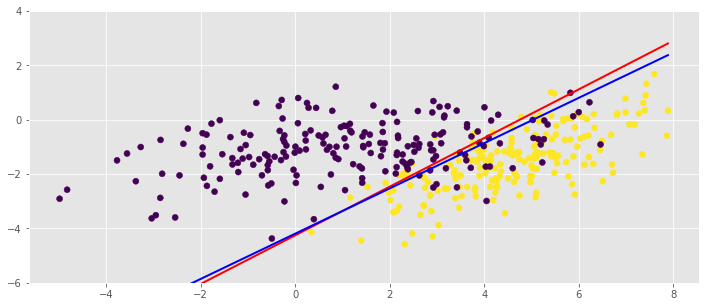

In [565]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]
y2 = np.r_[np.ones(200), -np.ones(200)]

# plot_decision_boundary(your_model)
model1 = MySGDClassifier( batch_generator, C=1000, alpha=0.01, max_epoch=300,model_type='lin_reg')
model2 = MySGDClassifier( batch_generator, C=1000, alpha=0.01, max_epoch=300, model_type ='log_reg')

model1.fit(X, y2)
model2.fit(X, y)

plt.scatter(X[:,0], X[:,1], c=y)
plot_decision_boundary(model2)
plot_decision_boundary(model1)

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [88]:
from sklearn.datasets import make_classification

In [349]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

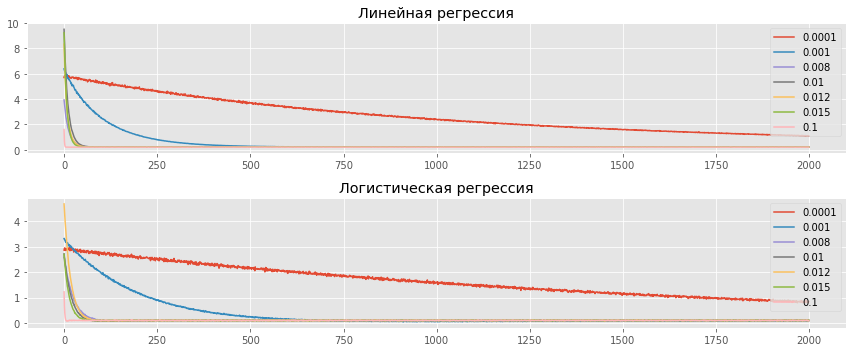

In [334]:
## Your Code Here
alphas = [0.0001, 0.001, 0.008, 0.01, 0.012, 0.015, 0.1]
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for alpha in alphas:
    model1 = MySGDClassifier(batch_generator, C=1, alpha=alpha, max_epoch=100,  model_type='lin_reg', batches = int(len(y)/20))
    model2 = MySGDClassifier(batch_generator, C=1, alpha=alpha, max_epoch=100, model_type='log_reg')
    model1.fit(X, y)
    model2.fit(X, y)
    
    ax1.plot(np.array(model1.errors_log['loss']).flatten(), label=r'$\alpha=%.3f$' % alpha)
    ax2.plot(np.array(model2.errors_log['loss']).flatten(), label=r'$\alpha=%.3f$' % alpha)
    
ax1.legend(alphas)
ax2.legend(alphas)
ax2.set_title('Логистическая регрессия')
ax1.set_title('Линейная регрессия')
plt.tight_layout()

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

### Ответ
0.1 хорошо подходит для данной задачи. Но лучше брать немного меньше, увеличивая количество эпох, так больше шансов, что не пропустим минимум(при дальнейшем увеличении альфа именно это и происходит). Так же можно ввести learning rate который будет равен уменьшенному значению alpha в n раз на n-ой итерации

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

/home/kirill/playground/env/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in true_divide
/home/kirill/playground/env/lib/python3.5/site-packages/ipykernel_launcher.py:60: RuntimeWarning: overflow encountered in true_divide


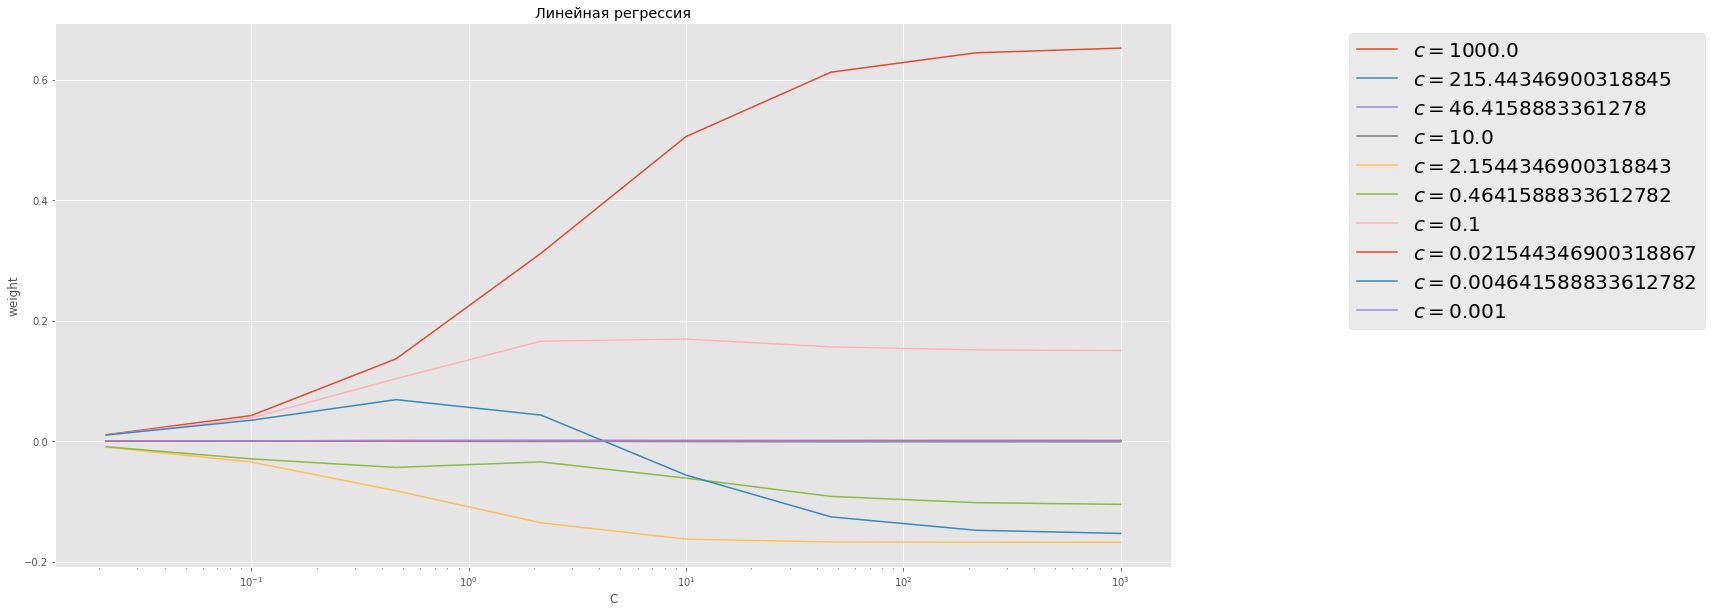

In [350]:
## Your Code Here
C = np.logspace(3, -3, 10)
N = X.shape[1] + 1
M = C.size
W = np.zeros((M, N))

for (i, c) in enumerate(C):
    model = MySGDClassifier(batch_generator, C=c, alpha=0.01, max_epoch=100, model_type = 'lin_reg',
                           batches = int(len(y)/20))
    model.fit(X, y)
    W[i, :] = model.weights.reshape(W[i,:].shape)
fig, ax = plt.subplots(figsize=(20, 10))
for i in range(N-1):
    ax.semilogx(C, W[:, i], label=('$c = {}$'.format(C[i])))

ax.legend(bbox_to_anchor=(1.15, 1), fontsize=20)
ax.set_ylabel('weight')
ax.set_xlabel('C')
ax.set_title('Линейная регрессия')
plt.show()

/home/kirill/playground/env/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/home/kirill/playground/env/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in true_divide
/home/kirill/playground/env/lib/python3.5/site-packages/ipykernel_launcher.py:60: RuntimeWarning: overflow encountered in true_divide


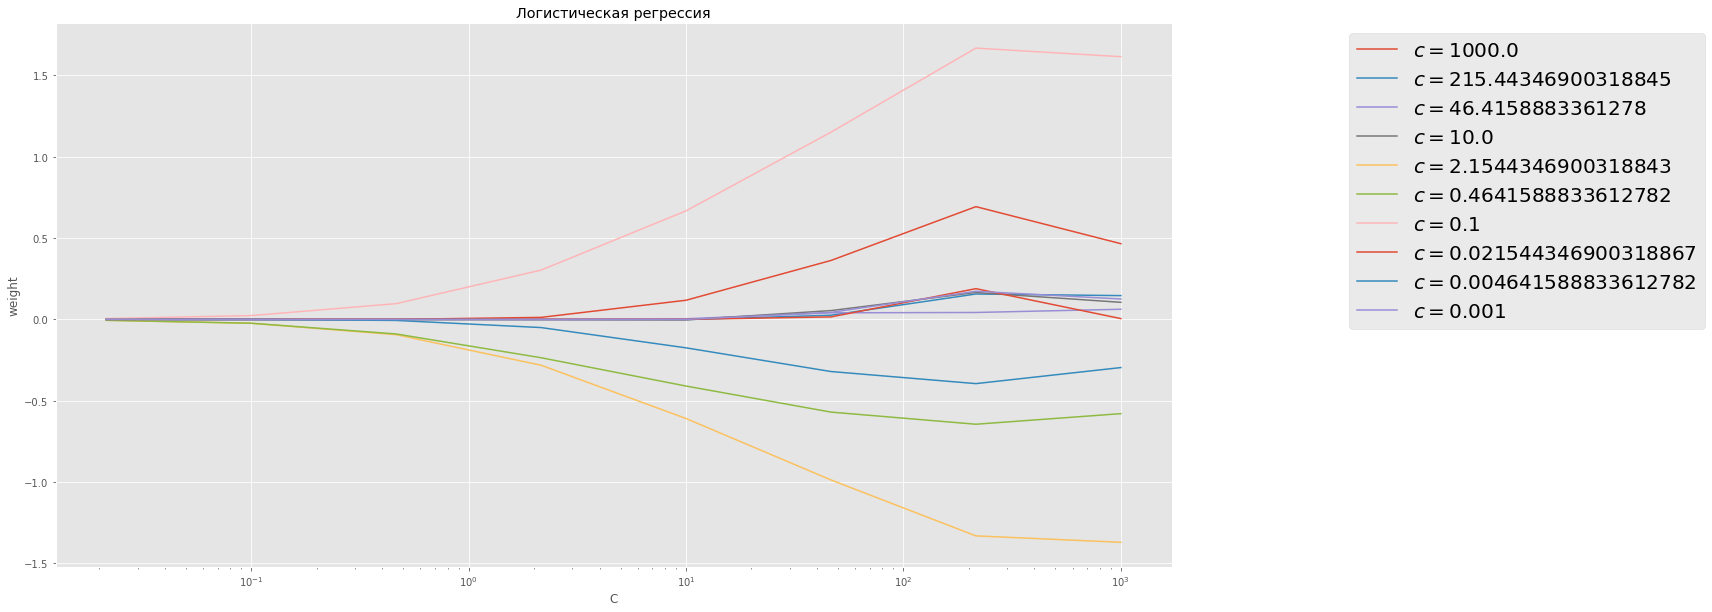

In [351]:
# Your Code Here
C = np.logspace(3, -3, 10)
N = X.shape[1] + 1
M = C.size
W = np.zeros((M, N))

for (i, c) in enumerate(C):
    model = MySGDClassifier(batch_generator, C=c, alpha=0.01, max_epoch=100, model_type = 'log_reg',
                           batches = int(len(y)/20))
    W[i, :] = model.weights.reshape(W[i,:].shape)
fig, ax = plt.subplots(figsize=(20, 10))
for i in range(N-1):
    ax.semilogx(C, W[:, i], label=('$c = {}$'.format(C[i])))

ax.legend(bbox_to_anchor=(1.15, 1), fontsize=20)
ax.set_ylabel('weight')
ax.set_xlabel('C')
ax.set_title('Логистическая регрессия')
plt.show()

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

Была построена зависимость не среднего значения а всех весов. На графике так выглядит нагляднее. Видно, что при C близком к 0 веса зануляются. Это происходит потому что мы на них делим, следовательно множетель получается большим.Значит мы слишком сильно штрафуем ошибку.  
Результатом доволен

# Боевое применение (3  балла)

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview-2.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [354]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print (len(doc_to_title))

28026


In [336]:
import pandas as pd
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [605]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:15]    )
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train.shape, y_train.shape, groups_train.shape)

(11690, 15) (11690,) (11690,)


Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [450]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from itertools import product
from sklearn.metrics import roc_auc_score, roc_curve

In [600]:
model = Pipeline([
    ('sclr', StandardScaler()),
    ('clf', MySGDClassifier(batch_generator)),
])

In [607]:
groups = train_data.group_id.unique()
Train_val = train_data[train_data['group_id'].isin(groups[:int(len(groups)*4/6)])]
Test_val = train_data[train_data['group_id'].isin(groups[int(len(groups)*4/6):])]


X_train = Train_val.drop('target', 1)
y_train = Train_val['target']

X_test = Test_val.drop('target', 1)
y_test = Test_val['target']
scaler.fit(X_test)
X_test = scaler.transform(X_test)
scaler.fit(X_train)
X = scaler.transform(X_train)

C = [100, 500]
alphas = [0.001, 0.005, 0.01, 0.05, 0.1]
batches = [1, 5, 10, 50]
max_epoch = 100

scores = []
params = []
parameters = product(C, alphas, batches)
parameters_list = list(parameters)

/home/kirill/playground/env/lib/python3.5/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/kirill/playground/env/lib/python3.5/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':
/home/kirill/playground/env/lib/python3.5/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/kirill/playground/env/lib/python3.5/site-packages/ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [ ]:
%%time
for param in tqdm(parameters_list, total = len(parameters_list)):
    model.set_params(clf__C=param[0],
                     clf__alpha=param[1],
                     clf__max_epoch=max_epoch,
                     clf__batches=param[2],
                     clf__model_type = 'log_reg')
    model.fit(X, y_train.values)
    y_pred = model.predict(X_test)
    scores.append(roc_auc_score(y_test, y_pred))
    params.append((param[0], param[1], param[2]))
    print(roc_auc_score(y_test, y_pred))

In [483]:
print('best score: %f' % np.max(scores))
best_params = params[np.argmax(scores)]

best score: 0.658733


In [745]:
model.set_params(clf__C=best_params[0],
                 clf__alpha=param[1],
                 clf__max_epoch=500,
                 clf__batches=param[2],
                 clf__model_type='log_reg')

model.fit(train_data.drop('target', 1), train_data['target'].values)

/home/kirill/playground/env/lib/python3.5/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/kirill/playground/env/lib/python3.5/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('sclr', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', MySGDClassifier(C=1, alpha=0.005,
        batch_generator=<function batch_generator at 0x7feaabb22e18>,
        batches=500, max_epoch=500, model_type='log_reg'))])

In [747]:
test_data = pd.read_csv('test_groups.csv')
y_pred_log = model.predict(test_data)

/home/kirill/playground/env/lib/python3.5/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [748]:
Counter(y_pred_log)

Counter({0: 14889, 1: 1738})

In [758]:
model.set_params(clf__C=best_params[0],
                 clf__alpha=param[1],
                 clf__max_epoch=500,
                 clf__batches=param[2]
                 clf__model_type='lin_reg')

model.fit(train_data.drop('target', 1), train_data['target'].values)

/home/kirill/playground/env/lib/python3.5/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/kirill/playground/env/lib/python3.5/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('sclr', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', MySGDClassifier(C=10, alpha=0.01,
        batch_generator=<function batch_generator at 0x7feaabb22e18>,
        batches=50, max_epoch=50, model_type='lin_reg'))])

In [759]:
y_pred_lin = model.predict(test_data)

/home/kirill/playground/env/lib/python3.5/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [762]:
nums = list(np.arange(11691, 28318))
df = pd.DataFrame({'pair_id': nums, 'target': y_pred_log})
df.to_csv('bukhteev_log.csv', index=False)

Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна. Если да, то Вы молодец!

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему линейных моделей и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите основные, на Ваш взгляд,  отличия логистической регрессии от линейной регрессии. Почему, на ваш взгляд, задачу классификации решают логистической, а не линейной регрессией?


***Ваше ответ здесь***

Логистическая регрессия предсказывает вероятность признаков и хорошо разделяет модель на малое число классов. Линейная регрессия предсказывает вещественные числа. Поэтому она подойдет лучше для задачи регрессии, чем для классификации


* Как Вы думаете, для каких типов задач (объем данных, число признаков, типы признаков) стоит отдавать предпочтение линейным моделям?



***Ваше ответ здесь***

Признаки должны быть только количественными. И самих признаков должно быть немного, потому что должна прослеживаться линейнай зависимость между признаками и целевой переменной. Если признаков много и все они коррелируют с целевой переменное, значит они и коррелируют между собой. Что будет приводить к ошибкам. Линейные модели позволяют обучаться потоков и не нужно постоянно хранить данные, что позволяет использовать модели при работе с очень большими данными. Так же они легко интерпретируемы, поэтому приветствуются в науке банке и других областях.

* Пусть на обучении мы имеем выборку размера $N$, число признаков $D$. Чему равна алгоритмическая сложность одного шага градиентного спуска? Cтохастического градиентного спуска?  Сложность предсказания на одном объекте?

***Ваше ответ здесь***

1)Для шага градиентного спуска  каждого $w_k$ где $k = 1,...,D$ вычисляется сумма из N слагаемых, в каждом слагаемом нужно вычислить скалярное произведение  $\langle x_i,w\rangle$, где $w$ вектор длины D.
В итоге получаем, алгоритмическая сложность одного шага градиентного спуска:
$$O(D * N * D) = O (N * D^2)$$
2)Для шага стохастического градиентного спуска нужен только один объект обучающей выборки, поэтому получаем, алгоритмическая сложность одного шага стохастического градиентного спуска:
$$O(D * 1 * D) = O (D^2)$$
3)Для предсказания на одном объекте нужно только вычислить  скалярное произведение двух векторов длины D. Тогда получаем, что алгоритмическая сложность:
$$O(D)$$

* В чем преимущества стохастического градиентного спуска (в том числе мини-батч) над обычным градиентным спуском? В чем его недостатки? Рассмотрите несколько аспектов $-$ скорость сходимости, необходимость загрузки всех данных в оперативную память, сложность вычисления одного шага.

***Ваше ответ здесь***

1) Для больших данных стохастический градиентый спуск подходит больше, так как скорость обучения гораздо выше.

2) Вычислительная сложность меньше у стохастического(предыдущий пункт)


* Как Вы думаете, при обучении линейной модели с помощью SGD, ошибку на новом объекте стоит считать до итерации спуска на этом объекте или после? Почему Вы так думаете? Возможно, Вам будет интересно ознакомиться с http://hunch.net/~jl/projects/prediction_bounds/thesis/mathml/thesisse44.xml

***Ваше ответ здесь***

 ошибку на новом объекте стоит считать до итерации спуска на этом объекте, так как тогда модель еще не видела этот объект

* Как Вы думаете, во времена такого бума нейронных сетей, остаются ли популярными линейные модели, или это уже пережиток прошлого? Почему Вы так думаете?

***Ваше ответ здесь***

Линейные модели быстро обучаются, легко интерпритируемы и простые, что нельзя сказать ни про одну нейронную сеть. Именно по этой пречине они все равно будут популярными

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

Все понятно

***Ваше ответ здесь***

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

Домашка сложная, но интересная.

*** ВАШ ОТЗЫВ ЗДЕСЬ***